In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from tensorflow.keras.utils import to_categorical, plot_model 
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Concatenate
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense

from keras.applications.vgg16 import VGG16, preprocess_input

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
# установка параметров нейросети
BATCH_SIZE = 16
BUFFER_SIZE = 128
epochs = 10

In [3]:
dataset, info = tfds.load('horses_or_humans', with_info=True)

In [4]:
dataset

{'train': <PrefetchDataset shapes: {image: (300, 300, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>,
 'test': <PrefetchDataset shapes: {image: (300, 300, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>}

In [5]:
info

tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_path='C:\\Users\\snetkova\\tensorflow_datasets\\horses_or_humans\\3.0.0',
    download_size=153.59 MiB,
    dataset_size=153.53 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
)

In [6]:
def normalize_c(input_image, label):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    #label -= 1
    return input_image, label

In [7]:
def load_image_train_c(datapoint):
    input_image = tf.image.resize(datapoint['image'],(128,128))
    label = datapoint['label']

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)


    input_image, label = normalize_c(input_image, label)

    return input_image, label

def load_image_test_c(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = label = datapoint['label']

    input_image, label = normalize_c(input_image, label)

    return input_image, label 

In [8]:
train = dataset['train'].map(load_image_train_c)
test = dataset['test'].map(load_image_test_c)

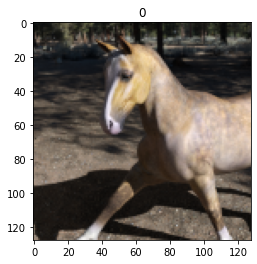

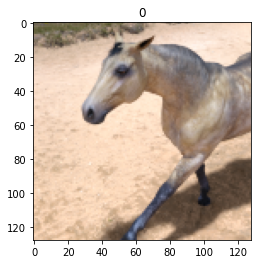

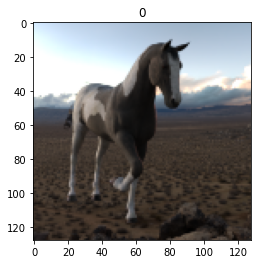

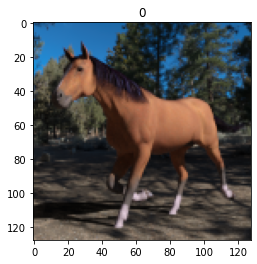

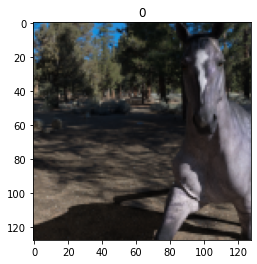

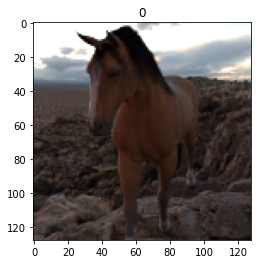

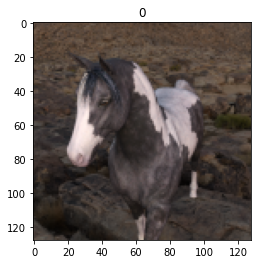

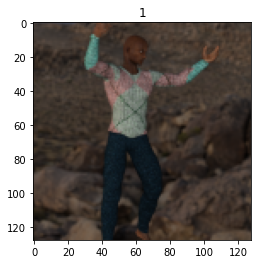

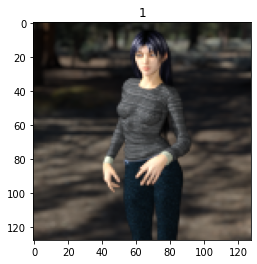

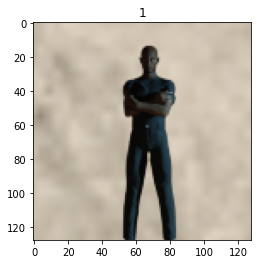

In [9]:
for image, label in train.take(10):
    sample_image, sample_label = image, label
    plt.imshow(sample_image.numpy()[:,:,:])
    plt.title(sample_label.numpy())
    plt.show()

In [10]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_dataset = train.batch(BATCH_SIZE)

In [11]:
test_dataset = test.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [12]:
classes = ['horse', 'human']

In [13]:
res = {}

### model

In [14]:
l_dim = 2
image_size = (image.shape[0], image.shape[1], image.shape[2])
vgg16_net = VGG16(weights='imagenet', include_top=False, input_shape=image_size)
vgg16_net.trainable = False
vgg16_net.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [15]:
model = Sequential()
model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits='True'), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model.summary()
model.save_weights('model1.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0

In [16]:
model.load_weights('model1.h5')
model_history = model.fit(train_dataset,
                  batch_size=BATCH_SIZE,
                  epochs=epochs,
                  validation_data=(test_dataset),
                  shuffle=True
                 )

Epoch 1/10
65/65 [==============================] - 47s 714ms/step - loss: 0.6098 - accuracy: 0.7906 - val_loss: 0.0663 - val_accuracy: 0.9648
Epoch 2/10
65/65 [==============================] - 46s 717ms/step - loss: 0.0481 - accuracy: 0.9831 - val_loss: 0.1575 - val_accuracy: 0.9531
Epoch 3/10
65/65 [==============================] - 46s 704ms/step - loss: 0.0086 - accuracy: 0.9996 - val_loss: 0.1730 - val_accuracy: 0.9375
Epoch 4/10
65/65 [==============================] - 46s 704ms/step - loss: 0.0180 - accuracy: 0.9952 - val_loss: 0.2410 - val_accuracy: 0.9219
Epoch 5/10
65/65 [==============================] - 45s 699ms/step - loss: 0.0057 - accuracy: 0.9978 - val_loss: 0.1775 - val_accuracy: 0.9492
Epoch 6/10
65/65 [==============================] - 46s 705ms/step - loss: 0.0061 - accuracy: 0.9957 - val_loss: 0.3030 - val_accuracy: 0.9297
Epoch 7/10
65/65 [==============================] - 45s 694ms/step - loss: 0.0062 - accuracy: 0.9977 - val_loss: 0.0162 - val_accuracy: 0.9922

In [17]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
res['model'] = [acc[-1], val_acc[-1]]

In [18]:
pd.DataFrame.from_dict(res, orient='index', columns = ['train_score', 'test_score'])

,train_score,test_score
model,1.0,0.972656


Гораздо выше, чем у alexnet - стайл

### data augmentation

In [19]:
train_datagen = ImageDataGenerator(
            featurewise_center=False,
            samplewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False, 
            zca_epsilon=1e-06, 
            rotation_range=10, 
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0., 
            zoom_range=0., 
            channel_shift_range=0.,
            fill_mode='nearest',
            cval=0.,
            horizontal_flip=True,
            vertical_flip=False,
            rescale=None,
            preprocessing_function=None,
            data_format=None,
            validation_split=0.0)
val_datagen = ImageDataGenerator()

In [20]:
model.load_weights('model1.h5')
g1 = tfds.as_numpy((train_dataset.take(-1)))
g2 = tfds.as_numpy((test_dataset.take(-1)))
for (x1, y1), (x2, y2) in zip(g1, g2):
    model_history = model.fit_generator(train_datagen.flow(x1, y1, batch_size=BATCH_SIZE), epochs=epochs, validation_data=val_datagen.flow(x2, y2, batch_size=BATCH_SIZE), workers=4)
    
# g2 = tfds.as_numpy((test_dataset.take(-1)))
# for x, y in g2:
#     datagen.fit(x)

C:\Users\snetkova\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.7497 - accuracy: 0.6250 - val_loss: 1.1044 - val_accuracy: 0.4375
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.5887 - accuracy: 0.6250 - val_loss: 0.7132 - val_accuracy: 0.5625
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 1.8339 - accuracy: 0.5625 - val_loss: 0.6292 - val_accuracy: 0.6875
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.4349 - accuracy: 0.8750 - val_loss: 1.1026 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.2679 - accuracy: 0.8750 - val_loss: 1.3322 - val_accuracy: 0.4375
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0964 - accuracy: 1.0000 - val_loss: 0.5680 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.4772 - accuracy: 0.8125 - val_loss: 0.5596 - val_accuracy: 0.8750
Epoch 8/10
1/1 [=========================

1/1 [==============================] - 1s 1s/step - loss: 0.0900 - accuracy: 0.9375 - val_loss: 0.2440 - val_accuracy: 0.9375
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.4566 - accuracy: 0.9375 - val_loss: 0.9203 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.3657 - accuracy: 0.9375 - val_loss: 0.7178 - val_accuracy: 0.9375
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.1536 - accuracy: 0.9375 - val_loss: 0.4951 - val_accuracy: 0.9375
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0403 - accuracy: 1.0000 - val_loss: 0.3460 - val_accuracy: 0.9375
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.4055 - accuracy: 0.8125 - val_loss: 0.3558 - val_accuracy: 0.9375
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.4289 - accuracy: 0.8750 - val_loss: 0.3662 - val_accuracy: 0.9375
Epoch 7/10
1/1 [==============================] - 1s

1/1 [==============================] - 1s 1s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 1s 1s/step - loss: 9.3469e-04 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.4299 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.4252 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.4232 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.1033 - accuracy: 0.9375 - val_loss: 0.3808 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.3413 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================]

In [21]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
res['aug'] = [acc[-1], val_acc[-1]]

In [22]:
pd.DataFrame.from_dict(res, orient='index', columns = ['train_score', 'test_score'])

,train_score,test_score
model,1.0,0.972656
aug,1.0,0.937500


На тесте получили результат чуть хуже

### preds

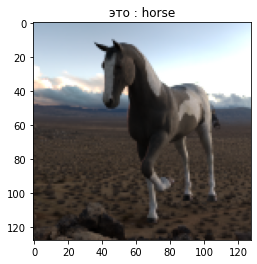

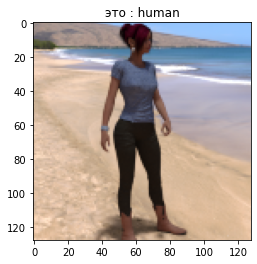

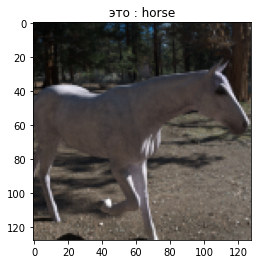

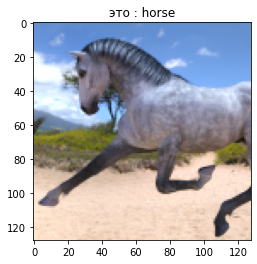

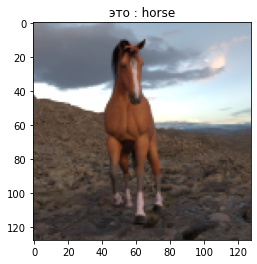

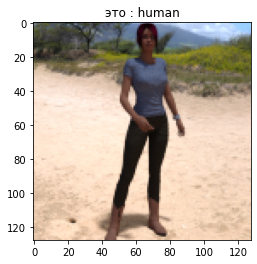

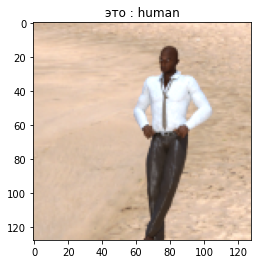

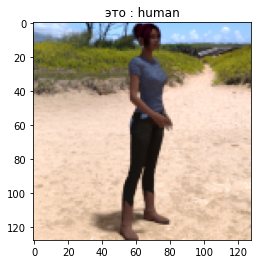

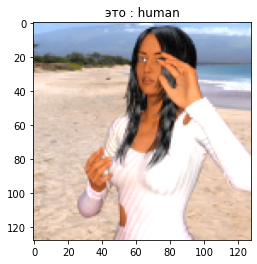

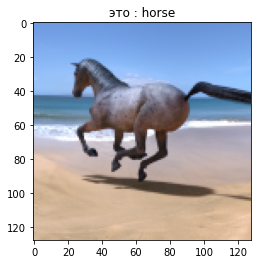

In [24]:
n = 2
for image, label in train_dataset.take(10):
    sample_image, sample_label = image, label

    x_test, y_label = image.numpy(), label.numpy()

    y_p = model.predict(x_test[:,:,:])
    y_pred = y_p.argmax(axis=-1)[n]
    plt.imshow(x_test[n,:,:])

    plt.title('это : '+ classes[y_pred])
    plt.show()

## SOM

Самоорганизующиеся карты Кохонена (Self Organizing Maps) - интсрумент, объединяющий кластеризацию и проецирование, т.е. визуализацию многомерных данных на плоскости. В отличие от нейронной сети обратного распространения, процедура настройки SOM относится к алгоритмами обучения без учителя. <br><br>
Сеть Кохонена имеет всего два слоя: входной и выходной, составленный из радиальных нейронов упорядоченной структуры (выходной слой называют также слоем топологической карты, или “экраном”). Нейроны выходного слоя располагаются в узлах двумерной сетки с прямоугольными или шестиугольными ячейками. Количество нейронов в сетке определяет степень детализации результата работы алгоритма, и, в конечном счете, от этого зависит точность обобщающей способности карты.

Объекты, векторы признаков которых оказываются ближе к вектору весов данного нейрона карты, попадают в ячейку, связанную с этим нейроном. Тогда распределение объектов на карте в целом соответствует распределению векторов весов нейронов в пространстве признаков. Следовательно, если объекты на карте расположены близко друг к другу, т.е. попали в одну ячейку или хотя бы в соседние, то и векторы признаков этих объектов близки. И наоборот, если объекты попали в ячейки, расположенные на карте далеко друг от друга, то и векторы их признаков различаются сильно.

Для обучения нейронов используется подход Стратегия Winner Takes All (WTA). На каждом шаге обучения мы определяем ближайший «победивший» нейрон и исходя из этого знания обновляем веса. Подгонка SOM заключается в итеративной настройке вектора весовых коэффициентов каждого нейрона, для чего используется модифицированный алгоритм соревновательного обучения Хебба, который учитывает не только вклад нейрона-победителя, но и ближайших его соседей, расположенных в окрестности.

Самоорганизующиеся карты Кохонена могут быть использованы для кластерного анализа только в том случае, если заранее известно число кластеров